# Test future weather

In [1]:
import besos.eppy_funcs as ef
from besos.evaluator import EvaluatorEH, EvaluatorEP
from besos.problem import EPProblem, EHProblem, Problem
from besos.objectives import VariableReader, MeterReader
from besos import objectives
from besos.parameters import RangeParameter, CategoryParameter, Parameter, FieldSelector, GenericSelector
from besos import config
import pvlib
import numpy as np
import pandas as pd
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime
import metpy.calc
import metrics.metrics
import seaborn

In [11]:
# Get the building model and specify the .epw
directory = './Building_models/5A_complete_data_sorted/no error/'
filename = 'SF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'#'MF+CZ5A+USA_IL_Chicago-OHare.Intl.AP.725300+gasfurnace+crawlspace+IECC_2018.idf'
building = ef.get_building(directory + filename)

In [2]:
count = 1
df = pd.DataFrame()
filenames = os.listdir('./future_weather')
if '.ipynb_checkpoints' in filenames: filenames.remove('.ipynb_checkpoints')
for filename in filenames:
    year = filename.split('_')[2]
    location = filename.split('_')[3][:-4]
    print(str(count) + ') ' + 'simulating building for year ' + year + ' and location ' + location)
    count = count + 1
    epw_path = './future_weather/' + filename

    # Set the cooling setpoint high so that HVAC system is not triggered during heatwave
    EPparameters = [] 
    EPparameters.append(Parameter(name='Cooling Setpoint (C)',
                               selector=FieldSelector(class_name='Schedule:Compact',
                                                      object_name='cooling_sch',field_name='Field 4'),
                               value_descriptors=RangeParameter(min_val=20.1,max_val=50)))
    
    EPparameters.append(Parameter(name='Heating Setpoint (C)',
                           selector=FieldSelector(class_name='Schedule:Compact',
                                                  object_name='heating_sch',field_name='Field 4'),
                           value_descriptors=RangeParameter(min_val=0,max_val=20)))

    # Collect air temperature and humidity as outputs across all zones.
    EPobjectives = []
    outputs = ['Zone Mean Air Temperature', 'Zone Air Relative Humidity']
    for output in outputs:
        for u in [1,]:
            for roomtype in ['LIVING', 'ATTIC', 'CRAWLSPACE']:
                EPobjectives.append(objectives.VariableReader(key_value = f'{roomtype}_UNIT{u}',variable_name = output, func=objectives.time_series_values))

    # Setting up the EnergyPlus simulation
    problem = EPProblem(EPparameters,EPobjectives)
    evaluator = EvaluatorEP(problem,building,epw=epw_path, out_dir='Outdir', err_dir='Errdir')

    # Running a single simulation with cooling set point specified to be 40°C
    results = evaluator.eval_single([50, 0])

    # Storing results (living space only)
    T = results[0]
    df[year + location + 'T'] = T
    RH = results[3]
    df[year + location + 'RH'] = RH

KeyboardInterrupt: 

In [13]:
#run old epw files
count=0
df_current = pd.DataFrame()
for filename in ['London_DSY3.epw','London_DSY1.epw','London_DSY2.epw']:#1976,1989,2003
    print(str(count) + ') ' + 'simulating building for measured weather data from London')
    count = count + 1
    epw_path = './existing_weatherfiles/current/' + filename

    # Set the cooling setpoint high so that HVAC system is not triggered during heatwave
    EPparameters = [] 
    EPparameters.append(Parameter(name='Cooling Setpoint (C)',
                               selector=FieldSelector(class_name='Schedule:Compact',
                                                      object_name='cooling_sch',field_name='Field 4'),
                               value_descriptors=RangeParameter(min_val=20.1,max_val=50)))
    
    EPparameters.append(Parameter(name='Heating Setpoint (C)',
                           selector=FieldSelector(class_name='Schedule:Compact',
                                                  object_name='heating_sch',field_name='Field 4'),
                           value_descriptors=RangeParameter(min_val=0,max_val=20)))

    # Collect air temperature and humidity as outputs across all zones.
    EPobjectives = []
    outputs = ['Zone Mean Air Temperature', 'Zone Air Relative Humidity']
    for output in outputs:
        for u in [1,]:
            for roomtype in ['LIVING', 'ATTIC', 'CRAWLSPACE']:
                EPobjectives.append(objectives.VariableReader(key_value = f'{roomtype}_UNIT{u}',variable_name = output, func=objectives.time_series_values))

    # Setting up the EnergyPlus simulation
    problem = EPProblem(EPparameters,EPobjectives)
    evaluator = EvaluatorEP(problem,building,epw=epw_path, out_dir='Outdir', err_dir='Errdir')

    # Running a single simulation with cooling set point specified to be 40°C
    results = evaluator.eval_single([50, 0])

    # Storing results (living space only)
    T = results[0]
    df_current[filename + 'T'] = T
    RH = results[3]
    df_current[filename + 'RH'] = RH

0) simulating building for measured weather data from London


/home/user/.local/lib/python3.7/site-packages/besos/problem.py:152: RuntimeWarning: Duplicate names found. (duplicate, repetitions): [('Zone Mean Air Temperature', 3), ('Zone Air Relative Humidity', 3)]
Attempting to fix automatically
  f"Duplicate names found. (duplicate, repetitions): "
/home/user/.local/lib/python3.7/site-packages/besos/objectives.py:225: UserWarning: `time_series_values` is incomplete, and returns raw values, not time series values.
  "`time_series_values` is incomplete, and returns raw values, not time series values."


1) simulating building for measured weather data from London
2) simulating building for measured weather data from London


In [14]:
df_current.to_csv('./simulations_current.csv')

In [12]:
#run old epw files
count=0
df_morphed = pd.DataFrame()
for filename in ['London_DSY3_85_2065_50.epw','London_DSY1_85_2065_50.epw','London_DSY2_85_2065_50.epw']:#1976,1989,2003
    print(str(count) + ') ' + 'simulating building for measured weather data from London')
    count = count + 1
    epw_path = './existing_weatherfiles/future/' + filename

    # Set the cooling setpoint high so that HVAC system is not triggered during heatwave
    EPparameters = [] 
    EPparameters.append(Parameter(name='Cooling Setpoint (C)',
                               selector=FieldSelector(class_name='Schedule:Compact',
                                                      object_name='cooling_sch',field_name='Field 4'),
                               value_descriptors=RangeParameter(min_val=20.1,max_val=50)))
    
    EPparameters.append(Parameter(name='Heating Setpoint (C)',
                           selector=FieldSelector(class_name='Schedule:Compact',
                                                  object_name='heating_sch',field_name='Field 4'),
                           value_descriptors=RangeParameter(min_val=0,max_val=20)))

    # Collect air temperature and humidity as outputs across all zones.
    EPobjectives = []
    outputs = ['Zone Mean Air Temperature', 'Zone Air Relative Humidity']
    for output in outputs:
        for u in [1,]:
            for roomtype in ['LIVING', 'ATTIC', 'CRAWLSPACE']:
                EPobjectives.append(objectives.VariableReader(key_value = f'{roomtype}_UNIT{u}',variable_name = output, func=objectives.time_series_values))

    # Setting up the EnergyPlus simulation
    problem = EPProblem(EPparameters,EPobjectives)
    evaluator = EvaluatorEP(problem,building,epw=epw_path, out_dir='Outdir', err_dir='Errdir')

    # Running a single simulation with cooling set point specified to be 40°C
    results = evaluator.eval_single([50, 0])

    # Storing results (living space only)
    T = results[0]
    df_morphed[filename + 'T'] = T
    RH = results[3]
    df_morphed[filename + 'RH'] = RH

0) simulating building for measured weather data from London


/home/user/.local/lib/python3.7/site-packages/besos/problem.py:152: RuntimeWarning: Duplicate names found. (duplicate, repetitions): [('Zone Mean Air Temperature', 3), ('Zone Air Relative Humidity', 3)]
Attempting to fix automatically
  f"Duplicate names found. (duplicate, repetitions): "
/home/user/.local/lib/python3.7/site-packages/besos/objectives.py:225: UserWarning: `time_series_values` is incomplete, and returns raw values, not time series values.
  "`time_series_values` is incomplete, and returns raw values, not time series values."


1) simulating building for measured weather data from London
2) simulating building for measured weather data from London


In [13]:
df_morphed.to_csv('./simulations_morphed.csv')

In [14]:
df = pd.read_csv('./simulations.csv')
years = list(range(2061, 2080))
locations = ['[279, 328]',]#['[299, 255]', '[227, 248]', '[287, 319]', '[279, 328]', '[230, 262]']
df_metric = pd.DataFrame()
for year in years:
    for location in locations:
        column = str(year) + location
        T = df[column + 'T']
        RH = df[column + 'RH']
        
        timeseries = metrics.metrics.cumulative_metric(T, RH, 'hourly', 'Temperature', 'timeseries')
        df_metric[column] = timeseries 
df_metric = df_metric.drop(labels=range(48))
df_metric.index = pd.date_range(start = f'01.01.2016', end= f'31.12.2016', freq='H')[:-1]

In [15]:
df_current = pd.read_csv('./simulations_current.csv')
years = list(range(2061, 2080))
df_metric_current = pd.DataFrame()
for filename in ['London_DSY3.epw','London_DSY1.epw','London_DSY2.epw']:#1976,1989,2003
        T = df_current[filename + 'T']
        RH = df_current[filename + 'RH']
        
        timeseries = metrics.metrics.cumulative_metric(T, RH, 'hourly', 'Temperature', 'timeseries')
        df_metric_current[filename] = timeseries 
df_metric_current = df_metric_current.drop(labels=range(48))
df_metric_current.index = pd.date_range(start = f'01.01.2016', end= f'31.12.2016', freq='H')[:-1]

In [17]:
df_morphed = pd.read_csv('./simulations_morphed.csv')
years = list(range(2061, 2080))
df_metric_morphed = pd.DataFrame()
for filename in ['London_DSY3_85_2065_50.epw','London_DSY1_85_2065_50.epw','London_DSY2_85_2065_50.epw']:#1976,1989,2003
        T = df_morphed[filename + 'T']
        RH = df_morphed[filename + 'RH']
        
        timeseries = metrics.metrics.cumulative_metric(T, RH, 'hourly', 'Temperature', 'timeseries')
        df_metric_morphed[filename] = timeseries 
df_metric_morphed = df_metric_morphed.drop(labels=range(48))
df_metric_morphed.index = pd.date_range(start = f'01.01.2016', end= f'31.12.2016', freq='H')[:-1]

In [18]:
import seaborn as sns
import warnings

In [19]:
warnings.filterwarnings("ignore")

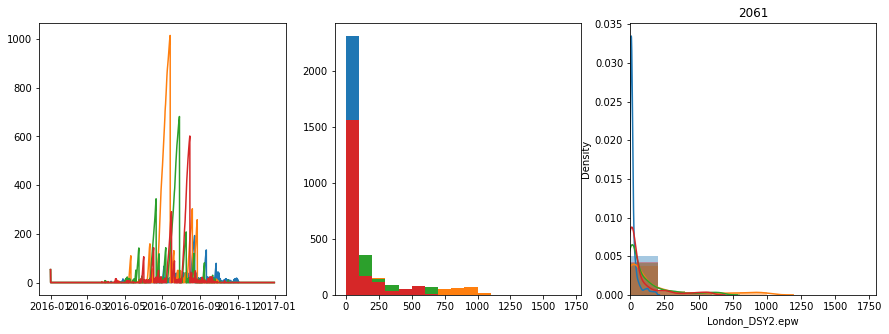

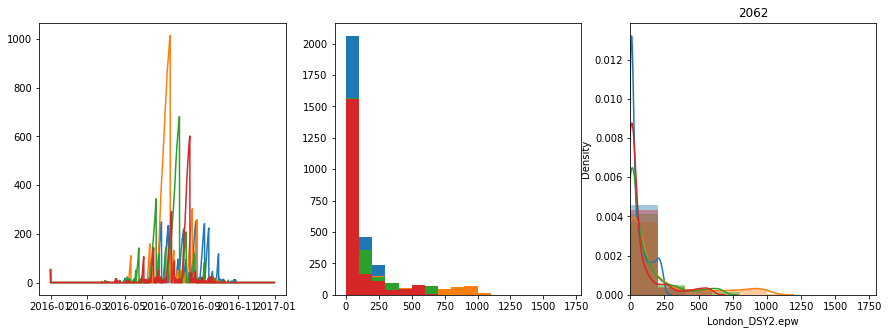

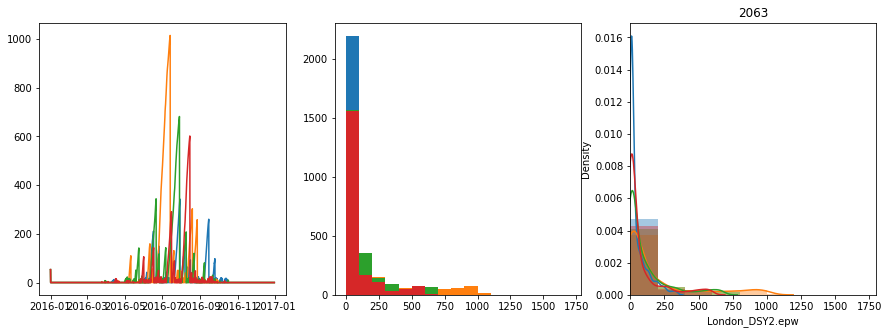

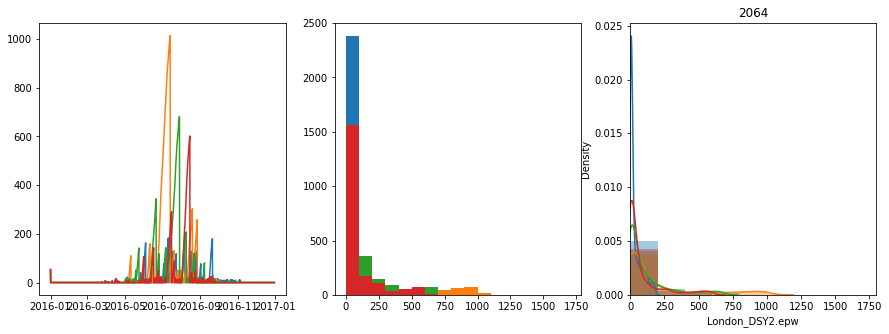

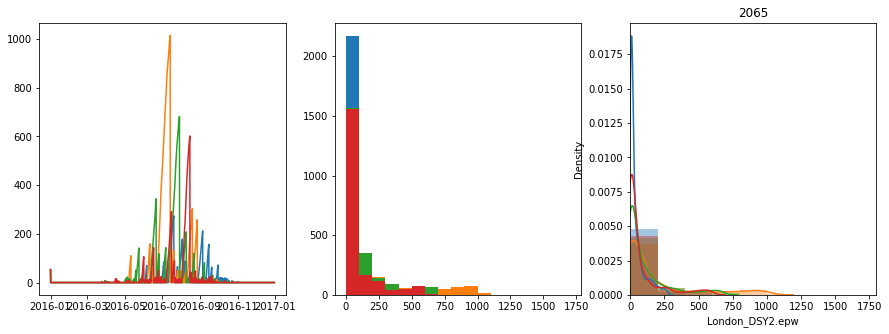

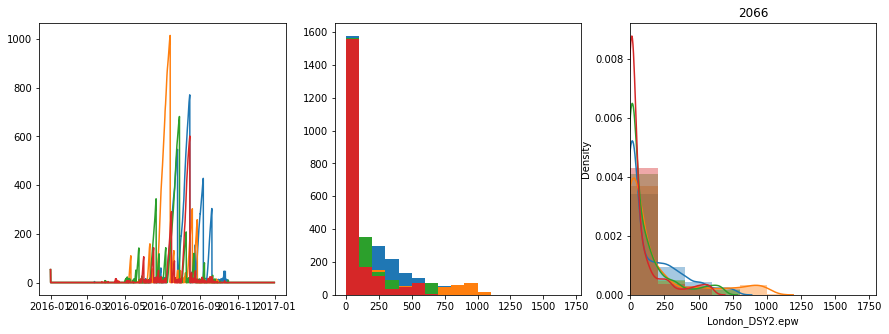

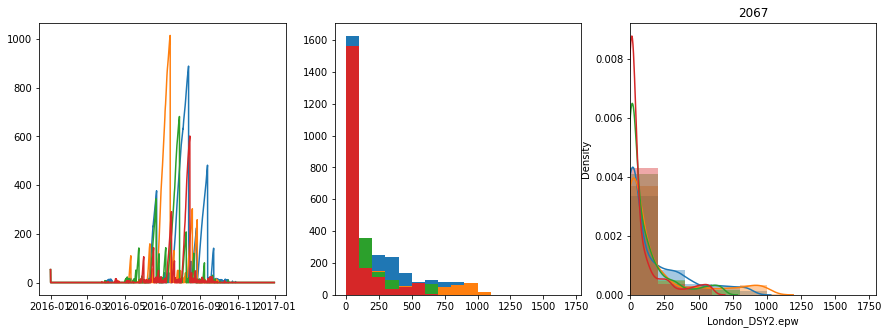

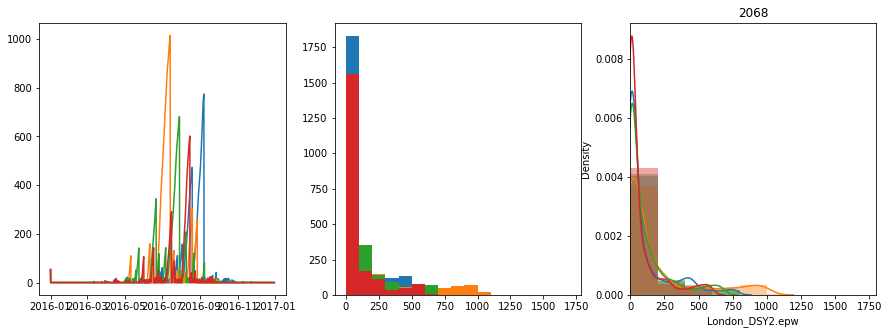

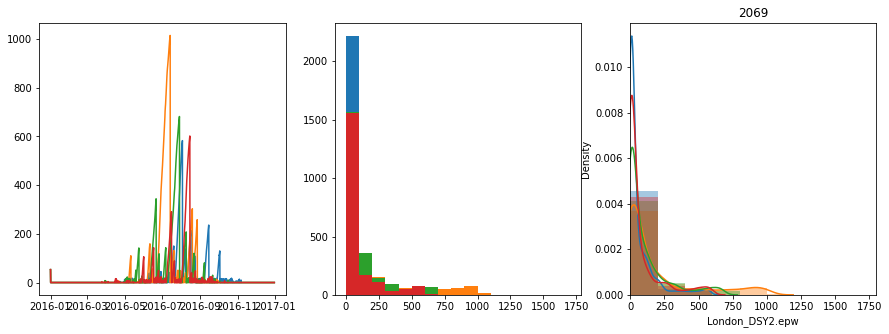

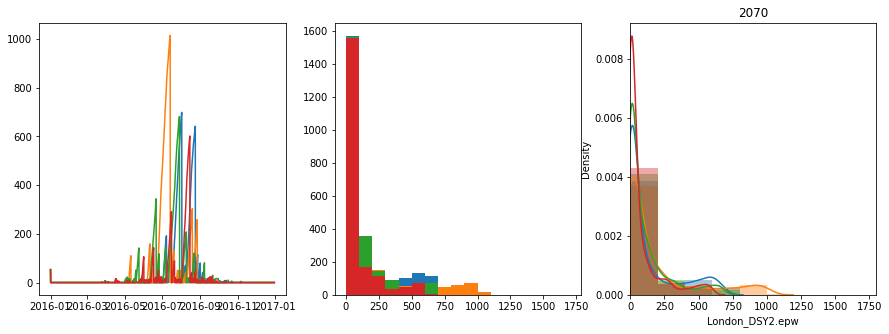

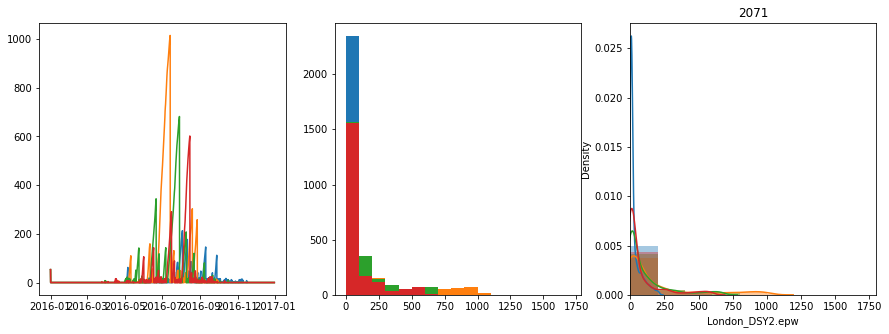

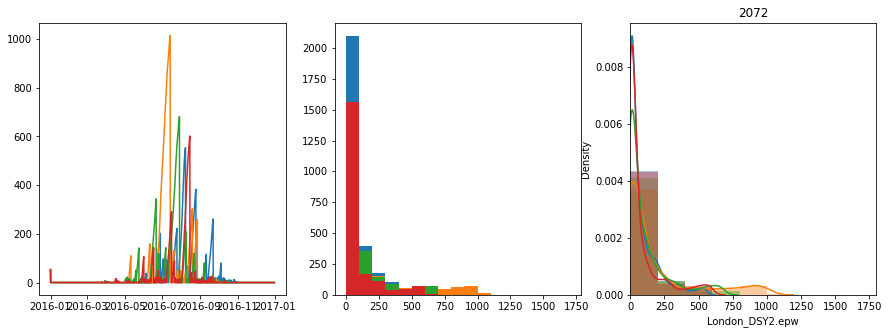

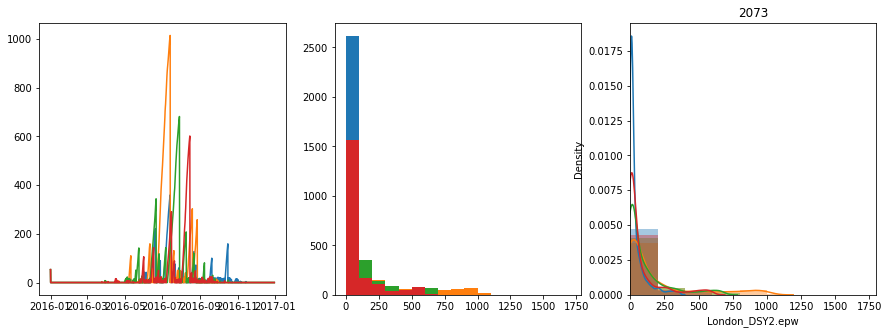

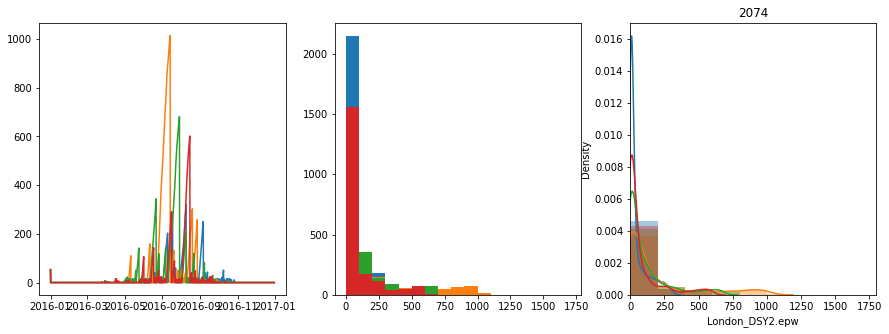

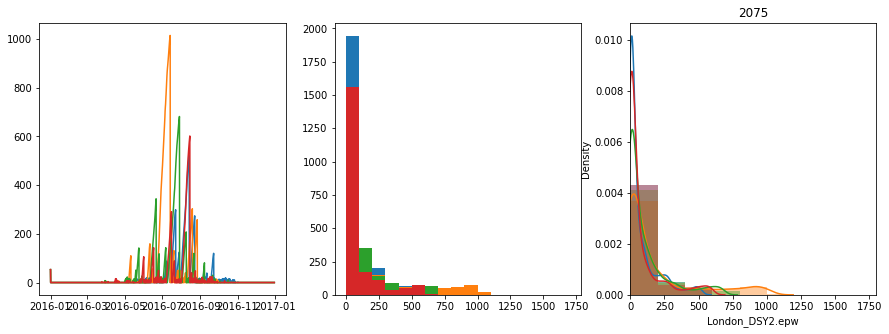

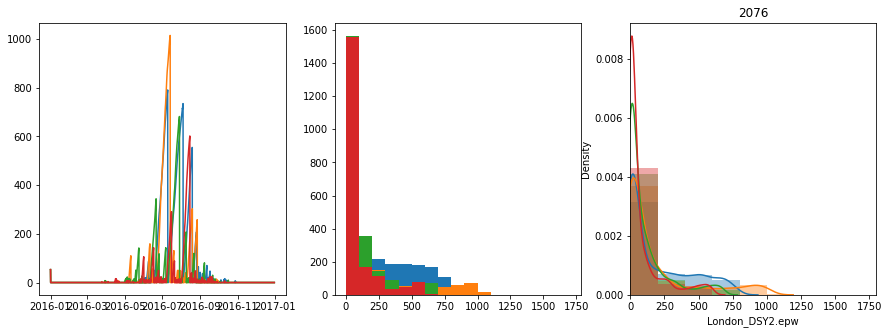

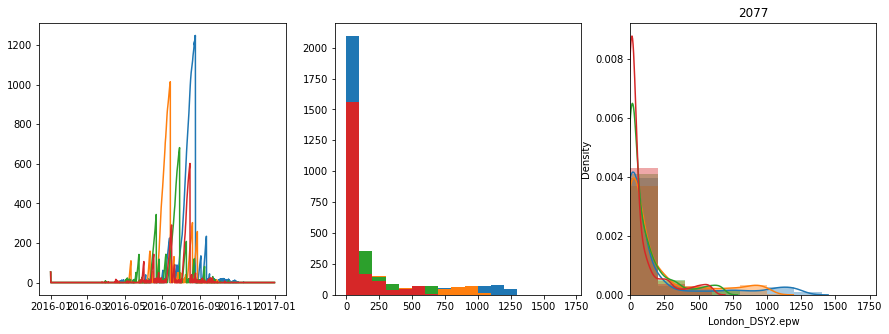

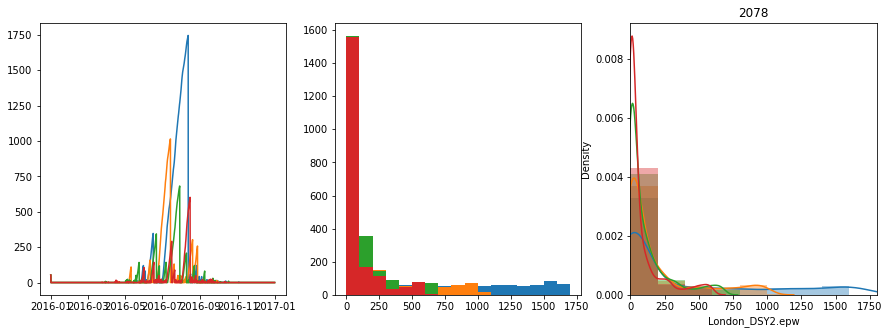

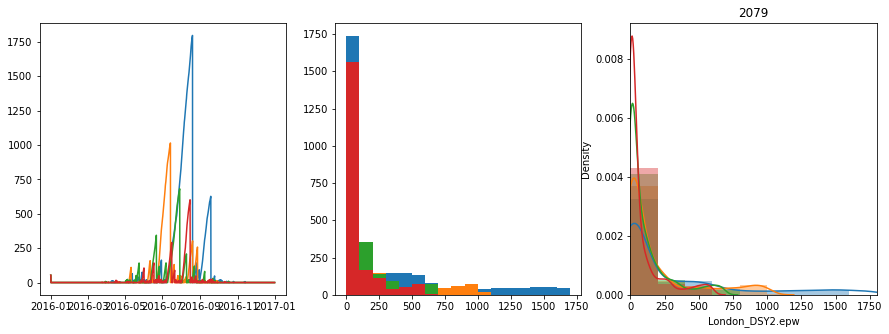

In [20]:
for year in years:
    _,ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].plot(df_metric[str(year) + '[279, 328]'])
    ax[1].hist(df_metric[str(year) + '[279, 328]'].loc[df_metric[str(year) + '[279, 328]']!=0], bins=range(0,1800,100))
    sns.distplot(df_metric[str(year) + '[279, 328]'].loc[df_metric[str(year) + '[279, 328]']!=0], ax=ax[2], bins=range(0,1800,200))
    summe=[]
    for filename in ['London_DSY3.epw','London_DSY1.epw','London_DSY2.epw']:
        ax[0].plot(df_metric_current[filename])
        ax[1].hist(df_metric_current[filename].loc[df_metric_current[filename]!=0], bins=range(0,1800,100))
        sns.distplot(df_metric_current[filename].loc[df_metric_current[filename]!=0], ax=ax[2], bins=range(0,1800,200) )
        summe.append(df_metric_current[filename].sum())
    s = df_metric[str(year) + '[279, 328]'].sum()
    #plt.legend([f'Future, total:{s}', f'1976, total: {summe[0]}', f'1989, total: {summe[1]}', f'2003, total: {summe[2]}'])
    ax[2].set_xlim([0,1800])
    plt.title(f'{year}')

In [63]:
# overall peak (intensity),
# duration of the longest heat wave (duration),
# number of waves longer > 24h (number of events),
# number wave days long > 24h 

In [60]:
def overall_peak(metric_ts):
    return np.max(metric_ts)

def longest_heat_wave(metric_ts):
    counter = 0
    counters =[]
    for i in metric_ts:
        if i == 0:
            counters.append(counter)
            counter = 0
        else:
            counter += 1
    counters.append(counter)
    return max(counters)/24
    
    
def n_heat_waves(metric_ts):
    counter = 0
    counters =[]
    for i in metric_ts:
        if i == 0:
            counters.append(counter)
            counter = 0
        else:
            counter += 1
    counters.append(counter)
    return sum(np.array(counters)>24)

def n_wave_days(metric_ts):
    counter = 0
    counters =[]
    for i in metric_ts:
        if i == 0:
            counters.append(counter)
            counter = 0
        else:
            counter += 1
    counters.append(counter)
    counters = np.array(counters)
    return sum(counters[counters>24])/24

In [61]:
results_table_current = pd.DataFrame()

results_table_current['Maximum intensity'] = df_metric_current.apply(overall_peak,axis=0).values
results_table_current['Longest heat wave'] = df_metric_current.apply(longest_heat_wave,axis=0).values
results_table_current['Number of events'] = df_metric_current.apply(n_heat_waves,axis=0).values
results_table_current['Number of wave days'] = df_metric_current.apply(n_wave_days,axis=0).values

In [ ]:
results_table_morphed = pd.DataFrame()

results_table_morphed['Maximum intensity'] = df_metric_morphed.apply(overall_peak,axis=0).values
results_table_morphed['Longest heat wave'] = df_metric_morphed.apply(longest_heat_wave,axis=0).values
results_table_morphed['Number of events'] = df_metric_morphed.apply(n_heat_waves,axis=0).values
results_table_morphed['Number of wave days'] = df_metric_morphed.apply(n_wave_days,axis=0).values

In [57]:
results_table = pd.DataFrame()
results_table['Maximum intensity'] = df_metric.apply(overall_peak,axis=0).values
results_table['Longest heat wave'] = df_metric.apply(longest_heat_wave,axis=0).values
results_table['Number of events'] = df_metric.apply(n_heat_waves,axis=0).values
results_table['Number of wave days'] = df_metric.apply(n_wave_days,axis=0).values

In [58]:
baseline_year= [1976, 1989, 2003]
diff_list = []
for i in range(3):
    diff = results_table-results_table_current.iloc[i,:]
    diff = diff>0
    diff_list.append(diff.sum()/20*100)
diff = pd.DataFrame(diff_list).transpose()
diff.columns=baseline_year
diff

1976  1989  2003
Maximum intensity    15.0  40.0  40.0
Longest heat wave    25.0  30.0  45.0
Number of events     80.0  30.0  90.0
Number of wave days  50.0  40.0  85.0

In [59]:
baseline_year= [1976, 1989, 2003]
diff_list = []
for i in range(3):
    diff = results_table-results_table_morphed.iloc[i,:]
    diff = diff>0
    diff_list.append(diff.sum()/20*100)
diff = pd.DataFrame(diff_list).transpose()
diff.columns=baseline_year
diff

1976  1989  2003
Maximum intensity     0.0   0.0  10.0
Longest heat wave    10.0   0.0  10.0
Number of events     40.0  95.0  25.0
Number of wave days   0.0  20.0   0.0

In [ ]:
[baseline_year.append(i) for i in range(2060,2080)]
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])

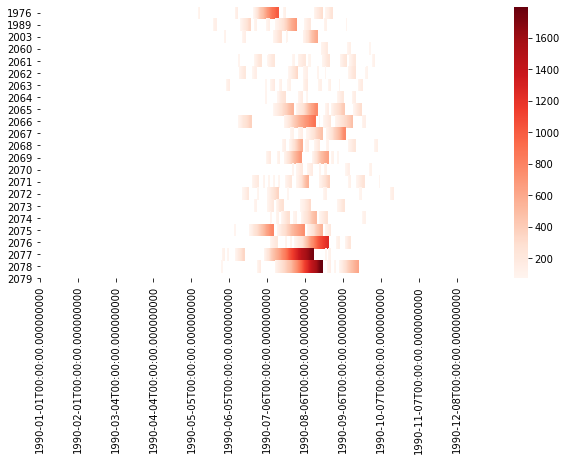

In [52]:
arr = df_metric[df_metric>72]
arr = arr.transpose().values
arr_current = df_metric_current[df_metric_current>72]
arr_current = arr_current.transpose().values
arr = np.vstack((arr_current, arr,))
plt.figure(figsize=(10,5))
arr = pd.DataFrame(arr, columns = pd.date_range('01.01.1990', '01.01.1991', freq='H')[:-1])
sns.heatmap(arr, cmap='Reds', yticklabels = baseline_year, xticklabels = 31*24)
ax = plt.gca()

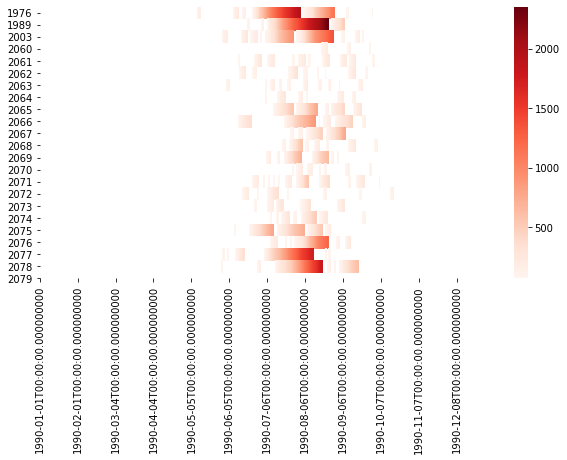

In [53]:
arr = df_metric[df_metric>72]
arr = arr.transpose().values
arr_morphed = df_metric_morphed[df_metric_morphed>72]
arr_morphed = arr_morphed.transpose().values
arr = np.vstack((arr_morphed, arr,))
plt.figure(figsize=(10,5))
arr = pd.DataFrame(arr, columns = pd.date_range('01.01.1990', '01.01.1991', freq='H')[:-1])
sns.heatmap(arr, cmap='Reds', yticklabels = baseline_year, xticklabels = 31*24)
ax = plt.gca()